In [5]:
#!/usr/bin/env python3
# Decision Tree (ID3) from scratch — FIXED to use local subsets

import math
from collections import Counter
import pandas as pd

df = pd.DataFrame({
    "Outlook":     ["Sunny","Sunny","Overcast","Rain","Rain","Rain","Overcast","Sunny","Sunny","Rain","Sunny","Overcast","Overcast","Rain"],
    "Temperature": ["Hot","Hot","Hot","Mild","Cool","Cool","Cool","Mild","Cool","Mild","Mild","Mild","Hot","Mild"],
    "Humidity":    ["High","High","High","High","Normal","Normal","Normal","High","Normal","Normal","Normal","High","Normal","High"],
    "Wind":        ["Weak","Strong","Weak","Weak","Weak","Strong","Strong","Weak","Weak","Weak","Strong","Strong","Weak","Strong"],
    "PlayTennis":  ["No","No","Yes","Yes","Yes","No","Yes","No","Yes","Yes","Yes","Yes","Yes","No"]
})

X_cols = ["Outlook","Temperature","Humidity","Wind"]
y_col  = "PlayTennis"

def entropy(labels):
    n = len(labels)
    counts = Counter(labels)
    return -sum((c/n) * math.log2(c/n) for c in counts.values())

def info_gain(df_local, feature, y_col):
    """Information gain computed on the *local* subset."""
    H_parent = entropy(df_local[y_col].tolist())
    n = len(df_local)
    weighted_child_entropy = 0.0
    for v in df_local[feature].unique():
        child = df_local[df_local[feature] == v]
        weighted_child_entropy += (len(child)/n) * entropy(child[y_col].tolist())
    return H_parent - weighted_child_entropy

class DTNode:
    def __init__(self, feature=None, children=None, prediction=None):
        self.feature = feature
        self.children = children or {}
        self.prediction = prediction

def majority_label(y_series):
    return Counter(y_series).most_common(1)[0][0]

def build_tree(df_local, features):
    y_series = df_local[y_col]
    # stop conditions
    if len(set(y_series)) == 1:
        return DTNode(prediction=y_series.iloc[0])
    if not features:
        return DTNode(prediction=majority_label(y_series))

    # pick best feature by IG on the *local* subset
    best_feat = max(features, key=lambda f: info_gain(df_local, f, y_col))
    node = DTNode(feature=best_feat)

    # recurse on each value using the *local* subset
    for v in df_local[best_feat].unique():
        child_df = df_local[df_local[best_feat] == v]
        if child_df.empty:
            node.children[v] = DTNode(prediction=majority_label(y_series))
        else:
            remaining = [f for f in features if f != best_feat]
            node.children[v] = build_tree(child_df, remaining)
    return node

# ---- Show IG at root (optional) ----
print("\n--- Information Gain at root ---")
for f in X_cols:
    print(f"{f}: {info_gain(df, f, y_col):.4f}")

# ---- Build and print the first-level structure ----
root = build_tree(df, X_cols)
print("\nDecision Tree root feature:", root.feature)
for v, child in root.children.items():
    print(f" ├── {root.feature}={v} → {child.prediction or child.feature}")



--- Information Gain at root ---
Outlook: 0.2467
Temperature: 0.0292
Humidity: 0.1518
Wind: 0.0481

Decision Tree root feature: Outlook
 ├── Outlook=Sunny → Humidity
 ├── Outlook=Overcast → Yes
 ├── Outlook=Rain → Wind



📊 Entropy / Gini / Info Gain Table (Root Level)

╒═════════════╤═══════════════════════╤══════════════════╕
│ Feature     │   Info Gain (Entropy) │   Gini Reduction │
╞═════════════╪═══════════════════════╪══════════════════╡
│ Outlook     │                0.2467 │           0.1163 │
├─────────────┼───────────────────────┼──────────────────┤
│ Temperature │                0.0292 │           0.0187 │
├─────────────┼───────────────────────┼──────────────────┤
│ Humidity    │                0.1518 │           0.0918 │
├─────────────┼───────────────────────┼──────────────────┤
│ Wind        │                0.0481 │           0.0306 │
╘═════════════╧═══════════════════════╧══════════════════╛


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



🔧 Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
🏆 Best CV Mean Accuracy: 0.6

📈 Performance on Test Data
Accuracy:  0.400
Precision: 0.500
Recall:    0.667
F1-score:  0.571

Confusion Matrix:
 [[0 2]
 [1 2]]

Classification Report:
               precision    recall  f1-score   support

          No       0.00      0.00      0.00         2
         Yes       0.50      0.67      0.57         3

    accuracy                           0.40         5
   macro avg       0.25      0.33      0.29         5
weighted avg       0.30      0.40      0.34         5


🔁 5-Fold Cross-Validation Accuracies: [0.667 0.667 0.333 0.333 0.5  ]
Mean CV Accuracy: 0.5


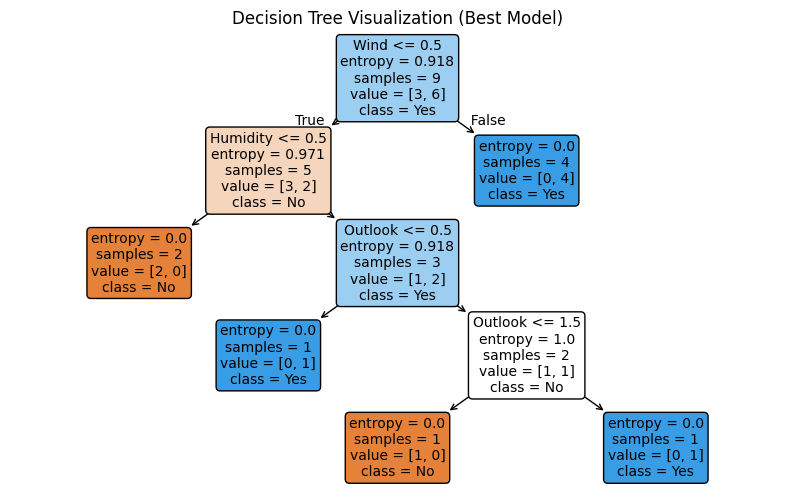


📋 Model Summary
╒═══════════════════╤═════════╕
│ Metric            │ Value   │
╞═══════════════════╪═════════╡
│ Criterion         │ entropy │
├───────────────────┼─────────┤
│ Max Depth         │         │
├───────────────────┼─────────┤
│ Min Samples Split │ 2       │
├───────────────────┼─────────┤
│ Train Size        │ 9       │
├───────────────────┼─────────┤
│ Test Size         │ 5       │
├───────────────────┼─────────┤
│ Test Accuracy     │ 0.400   │
├───────────────────┼─────────┤
│ Mean CV Accuracy  │ 0.500   │
╘═══════════════════╧═════════╛


In [9]:
#!/usr/bin/env python3
# ============================================================
# Decision Tree Classifier — PlayTennis Dataset
# Includes:
#   • Entropy / Gini / Information Gain comparison
#   • Hyperparameter tuning (GridSearchCV)
#   • Cross-validation
#   • Evaluation metrics
#   • Tree visualization
# ============================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
from tabulate import tabulate
import math
from collections import Counter

# ------------------------------------------------------------
# 1️⃣ Dataset
# ------------------------------------------------------------
df = pd.DataFrame({
    "Outlook":     ["Sunny","Sunny","Overcast","Rain","Rain","Rain","Overcast","Sunny","Sunny","Rain","Sunny","Overcast","Overcast","Rain"],
    "Temperature": ["Hot","Hot","Hot","Mild","Cool","Cool","Cool","Mild","Cool","Mild","Mild","Mild","Hot","Mild"],
    "Humidity":    ["High","High","High","High","Normal","Normal","Normal","High","Normal","Normal","Normal","High","Normal","High"],
    "Wind":        ["Weak","Strong","Weak","Weak","Weak","Strong","Strong","Weak","Weak","Weak","Strong","Strong","Weak","Strong"],
    "PlayTennis":  ["No","No","Yes","Yes","Yes","No","Yes","No","Yes","Yes","Yes","Yes","Yes","No"]
})

X = df.drop("PlayTennis", axis=1)
y = df["PlayTennis"]

# ------------------------------------------------------------
# 2️⃣ Encode categorical data
# ------------------------------------------------------------
oe = OrdinalEncoder(dtype=int)
X_enc = oe.fit_transform(X)

le = LabelEncoder()
y_enc = le.fit_transform(y)

# ------------------------------------------------------------
# 3️⃣ Entropy, Gini, and Information Gain calculation
# ------------------------------------------------------------
def entropy(labels):
    n = len(labels)
    counts = Counter(labels)
    return -sum((c/n) * math.log2(c/n) for c in counts.values())

def gini(labels):
    n = len(labels)
    counts = Counter(labels)
    return 1 - sum((c/n)**2 for c in counts.values())

def info_gain(df_local, feature, y_col):
    H_parent = entropy(df_local[y_col])
    n = len(df_local)
    weighted_entropy = sum(
        (len(subset)/n) * entropy(subset[y_col])
        for _, subset in df_local.groupby(feature)
    )
    return H_parent - weighted_entropy

print("\n📊 Entropy / Gini / Info Gain Table (Root Level)\n")
table = []
for f in X.columns:
    IG = info_gain(df, f, "PlayTennis")
    parent_H = entropy(df["PlayTennis"])
    parent_G = gini(df["PlayTennis"])
    weighted_G = sum((len(subset)/len(df)) * gini(subset["PlayTennis"]) for _, subset in df.groupby(f))
    gini_reduction = parent_G - weighted_G
    table.append([f, round(IG, 4), round(gini_reduction, 4)])
print(tabulate(table, headers=["Feature", "Info Gain (Entropy)", "Gini Reduction"], tablefmt="fancy_grid"))

# ------------------------------------------------------------
# 4️⃣ Train/test split
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y_enc, test_size=0.3, stratify=y_enc, random_state=42
)

# ------------------------------------------------------------
# 5️⃣ Hyperparameter tuning (GridSearchCV)
# ------------------------------------------------------------
param_grid = {
    "criterion": ["entropy", "gini"],
    "max_depth": [None, 2, 3, 4],
    "min_samples_split": [2, 3, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("\n🔧 Best Parameters:", grid.best_params_)
print("🏆 Best CV Mean Accuracy:", round(grid.best_score_, 4))

# ------------------------------------------------------------
# 6️⃣ Evaluate best model
# ------------------------------------------------------------
best_dt = grid.best_estimator_
y_pred = best_dt.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)

print("\n📈 Performance on Test Data")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n",
      classification_report(y_test, y_pred, target_names=le.classes_))

# ------------------------------------------------------------
# 7️⃣ Cross-Validation (manual check)
# ------------------------------------------------------------
cv_scores = cross_val_score(best_dt, X_enc, y_enc, cv=cv, scoring="accuracy")
print("\n🔁 5-Fold Cross-Validation Accuracies:", np.round(cv_scores, 3))
print("Mean CV Accuracy:", np.mean(cv_scores).round(3))

# ------------------------------------------------------------
# 8️⃣ Visualize the Decision Tree
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
plot_tree(
    best_dt,
    feature_names=X.columns,
    class_names=le.classes_,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization (Best Model)")
plt.show()

# ------------------------------------------------------------
# 9️⃣ Final Summary Table
# ------------------------------------------------------------
summary = [
    ["Criterion", grid.best_params_["criterion"]],
    ["Max Depth", grid.best_params_["max_depth"]],
    ["Min Samples Split", grid.best_params_["min_samples_split"]],
    ["Train Size", len(X_train)],
    ["Test Size", len(X_test)],
    ["Test Accuracy", f"{acc:.3f}"],
    ["Mean CV Accuracy", f"{np.mean(cv_scores):.3f}"],
]
print("\n📋 Model Summary")
print(tabulate(summary, headers=["Metric", "Value"], tablefmt="fancy_grid"))


In [11]:
#!/usr/bin/env python3
# ============================================================
# Naive Bayes (scikit-learn) for PlayTennis
# Features: Outlook, Temperature
# Target  : PlayTennis
# Includes:
#   • Robust categorical encoding for CategoricalNB
#   • Hyperparameter tuning (GridSearchCV) on alpha
#   • Stratified CV (3-fold, small dataset)
#   • Train/test split evaluation metrics
#   • Prediction for (Sunny, Hot) with probabilities
# ============================================================

import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, balanced_accuracy_score
)

# -------------------------
# 1) Dataset (ONLY the 2 inputs we care about)
# -------------------------
df = pd.DataFrame({
    "Outlook":     ["Sunny","Sunny","Overcast","Rain","Rain","Rain","Overcast",
                    "Sunny","Sunny","Rain","Sunny","Overcast","Overcast","Rain"],
    "Temperature": ["Hot","Hot","Hot","Mild","Cool","Cool","Cool",
                    "Mild","Cool","Mild","Mild","Mild","Hot","Mild"],
    "PlayTennis":  ["No","No","Yes","Yes","Yes","No","Yes",
                    "No","Yes","Yes","Yes","Yes","Yes","No"]
})

X = df[["Outlook", "Temperature"]]
y = df["PlayTennis"]

# -------------------------
# 2) Encode categories (robustly for CategoricalNB)
#    • dtype=int ensures discrete indices (0..k-1)
#    • handle_unknown maps unseen categories to -1 (safe in CV)
# -------------------------
oe = OrdinalEncoder(dtype=int, handle_unknown="use_encoded_value", unknown_value=-1)
X_enc = oe.fit_transform(X)

le = LabelEncoder()
y_enc = le.fit_transform(y)  # 0 = No, 1 = Yes (alphabetical)

# -------------------------
# 3) Train/Test split (stratified)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y_enc, test_size=0.3, stratify=y_enc, random_state=42
)

# -------------------------
# 4) Hyperparameter tuning + Cross-Validation
#    • Use 3 folds (dataset is tiny)
#    • Tune Laplace smoothing alpha
# -------------------------
param_grid = {"alpha": [0.25, 0.5, 1.0, 1.5, 2.0]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

grid = GridSearchCV(
    estimator=CategoricalNB(),
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_nb = grid.best_estimator_
print("Best parameters:", grid.best_params_)
print("Best CV mean accuracy:", round(grid.best_score_, 4))

# Optional: show CV scores of the chosen model on the full data
cv_scores = cross_val_score(best_nb, X_enc, y_enc, cv=cv, scoring="accuracy")
print("CV scores (3-fold, full data):", np.round(cv_scores, 3))
print("CV mean accuracy (full data):", round(cv_scores.mean(), 3))

# -------------------------
# 5) Evaluate on held-out test set
# -------------------------
y_pred = best_nb.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
bacc = balanced_accuracy_score(y_test, y_pred)  # helpful for imbalance
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary", zero_division=0
)

print("\n--- Test Set Performance ---")
print(f"Accuracy:            {acc:.3f}")
print(f"Balanced Accuracy:   {bacc:.3f}")
print(f"Precision (Yes=1):   {prec:.3f}")
print(f"Recall (Yes=1):      {rec:.3f}")
print(f"F1 (Yes=1):          {f1:.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n",
      classification_report(y_test, y_pred, target_names=le.classes_))

# -------------------------
# 6) Predict for (Sunny, Hot) with probabilities
# -------------------------
query_df  = pd.DataFrame([["Sunny", "Hot"]], columns=["Outlook", "Temperature"])
query_enc = oe.transform(query_df)  # uses same encoder as training

pred_class = best_nb.predict(query_enc)[0]
pred_proba = best_nb.predict_proba(query_enc)[0]

print("\n--- Prediction for (Outlook=Sunny, Temperature=Hot) ---")
print("Encoded query:", query_enc.tolist())
print("Predicted class:", le.inverse_transform([pred_class])[0])
print(f"Prob(No)  = {pred_proba[0]:.4f}")
print(f"Prob(Yes) = {pred_proba[1]:.4f}")


Best parameters: {'alpha': 1.0}
Best CV mean accuracy: 0.5556
CV scores (3-fold, full data): [0.2  0.4  0.25]
CV mean accuracy (full data): 0.283

--- Test Set Performance ---
Accuracy:            0.800
Balanced Accuracy:   0.750
Precision (Yes=1):   0.750
Recall (Yes=1):      1.000
F1 (Yes=1):          0.857

Confusion Matrix:
 [[1 1]
 [0 3]]

Classification Report:
               precision    recall  f1-score   support

          No       1.00      0.50      0.67         2
         Yes       0.75      1.00      0.86         3

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5


--- Prediction for (Outlook=Sunny, Temperature=Hot) ---
Encoded query: [[2, 1]]
Predicted class: No
Prob(No)  = 0.5294
Prob(Yes) = 0.4706


In [10]:
#!/usr/bin/env python3
# ============================================================
# Naive Bayes Classifier from Scratch
# Features: Outlook, Temperature
# Target  : PlayTennis
# Prediction: (Sunny, Hot)
# ============================================================

import pandas as pd
from collections import Counter

# -------------------------
# 1️⃣ Dataset
# -------------------------
df = pd.DataFrame({
    "Outlook":     ["Sunny","Sunny","Overcast","Rain","Rain","Rain","Overcast",
                    "Sunny","Sunny","Rain","Sunny","Overcast","Overcast","Rain"],
    "Temperature": ["Hot","Hot","Hot","Mild","Cool","Cool","Cool",
                    "Mild","Cool","Mild","Mild","Mild","Hot","Mild"],
    "PlayTennis":  ["No","No","Yes","Yes","Yes","No","Yes",
                    "No","Yes","Yes","Yes","Yes","Yes","No"]
})

features = ["Outlook", "Temperature"]
target   = "PlayTennis"

# -------------------------
# 2️⃣ Priors:  P(Yes), P(No)
# -------------------------
n = len(df)
class_counts = Counter(df[target])
priors = {cls: class_counts[cls]/n for cls in class_counts}
print("🎯 Class Priors P(class):")
for c, p in priors.items():
    print(f"  P({c}) = {p:.4f}")
print()

# -------------------------
# 3️⃣ Conditional probabilities  P(feature=value | class)
# -------------------------
alpha = 1  # Laplace smoothing
cond_probs = {}

for cls in class_counts:
    cond_probs[cls] = {}
    subset = df[df[target] == cls]
    for f in features:
        cond_probs[cls][f] = {}
        values = df[f].unique()
        k = len(values)
        for v in values:
            num = len(subset[subset[f] == v]) + alpha
            denom = len(subset) + alpha * k
            cond_probs[cls][f][v] = num / denom

print("📊 Conditional Probabilities P(x_i|class):\n")
for cls in cond_probs:
    print(f"Class = {cls}")
    for f in cond_probs[cls]:
        probs = ", ".join([f"{val}:{cond_probs[cls][f][val]:.3f}" for val in cond_probs[cls][f]])
        print(f"  {f:<12} → {probs}")
    print()

# -------------------------
# 4️⃣ Prediction for (Sunny, Hot)
# -------------------------
test = {"Outlook": "Sunny", "Temperature": "Hot"}
scores = {}

print("🔮 Step-by-Step Probability Computation:\n")
for cls in class_counts:
    prob = priors[cls]
    print(f"→ Start with P({cls}) = {prob:.4f}")
    for f in features:
        p_x_given_c = cond_probs[cls][f][test[f]]
        prob *= p_x_given_c
        print(f"   × P({f}={test[f]} | {cls}) = {p_x_given_c:.4f}")
    scores[cls] = prob
    print(f"   = Joint Probability P(X,{cls}) = {prob:.8f}\n")

# -------------------------
# 5️⃣ Normalize to get posterior P(class|X)
# -------------------------
total = sum(scores.values())
posterior = {c: scores[c]/total for c in scores}
pred_class = max(posterior, key=posterior.get)

print("📈 Posterior Probabilities P(class|Sunny,Hot):")
for c, p in posterior.items():
    print(f"  P({c}|X) = {p:.4f}")

print(f"\n✅ Final Prediction:  PlayTennis = {pred_class}")


🎯 Class Priors P(class):
  P(No) = 0.3571
  P(Yes) = 0.6429

📊 Conditional Probabilities P(x_i|class):

Class = No
  Outlook      → Sunny:0.500, Overcast:0.125, Rain:0.375
  Temperature  → Hot:0.375, Mild:0.375, Cool:0.250

Class = Yes
  Outlook      → Sunny:0.250, Overcast:0.417, Rain:0.333
  Temperature  → Hot:0.250, Mild:0.417, Cool:0.333

🔮 Step-by-Step Probability Computation:

→ Start with P(No) = 0.3571
   × P(Outlook=Sunny | No) = 0.5000
   × P(Temperature=Hot | No) = 0.3750
   = Joint Probability P(X,No) = 0.06696429

→ Start with P(Yes) = 0.6429
   × P(Outlook=Sunny | Yes) = 0.2500
   × P(Temperature=Hot | Yes) = 0.2500
   = Joint Probability P(X,Yes) = 0.04017857

📈 Posterior Probabilities P(class|Sunny,Hot):
  P(No|X) = 0.6250
  P(Yes|X) = 0.3750

✅ Final Prediction:  PlayTennis = No
